# Sentinel-1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc)

## Background

The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) mission is composed of a constellation of two Synthetic Aperture Radar (SAR) satellites, Sentinel-1A and Sentinel-1B, sharing the same orbital plane. Sentinel-1 provides dual polarisation capability, very short revisit times, and rapid product delivery. The mission currently collects data every 12 days over Africa at a spatial resolution of approximately 20m. Sentinel-1A was launched on 3 April 2014 and Sentinel-1B followed on 25 April 2016. Two other spacecraft (Sentinel-1C and Sentinel-1D) are planned to replace the first two satellites at the end of their operational lifespan. For more information on the Sentinel-1 platforms and applications, check out the [European Space Agency](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1) website.

SAR data has the advantage of operating at wavelengths not impeded by cloud cover and can acquire data over a site during the day or night. The Sentinel-1 mission is the European Radar Observatory for the Copernicus joint initiative of the European Commission (EC) and the European Space Agency (ESA) that can offer reliable and repeated wide area monitoring with its SAR instrument.

Radar backscatter measures the amount of microwave radiation reflected back to the centre from the ground surface. This measurement is sensitive to surface roughness, moisture content, and viewing geometry. DEAfrica provides Sentinel-1 backscatter as Radiometric Terrain Corrected (RTC) gamma-0 (γ0) where variation due to changing observation geometries has been mitigated.

DE Africa provides Sentinel-1 data acquired in Interferometric Wide Swath (IW) mode and with dual polarisation (VV and VH). The dual polarisation backscatter timeseries can be used in applications for forests, agriculture, wetlands, and land cover classification. SAR's ability to see through clouds makes it critical for mapping and monitoring land cover changes in the wet tropics. 

DEAfrica Sentinel-1 backscatter is processed to be compliant with the [CEOS Analysis Ready Data for Land (CARD4L)](https://ceos.org/ard/) specification. More technical information can be found in the [DE Africa User Guide](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-1_specs.html).


## Description

In this notebook we will load sentinel-1 Radiometric Terrain Corrected (RTC) SAR backscatter data using `dc.load()` to return a time series of satellite images. The returned xarray.Dataset dataset will contain analysis ready images over Ghana in 2021.

Topics covered include:
1. Inspecting the Sentinel-1 product and measurements available in the datacube
2. Using the native `dc.load()` function to load in Sentinel-1 data

An example of using Sentinel-1 for classify water is available under the `Real_world_examples` folder, [Radar Water Detection](../Real_world_examples/Radar_water_detection.ipynb)
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.


### Load packages

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb
from odc.algo import to_f32, xr_geomedian, int_geomedian

from datacube.utils.aws import configure_s3_access
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.classification import HiddenPrints
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_1")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's SAR products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,product_type,gqa_abs_y,gqa_stddev_xy,gqa_stddev_x,gqa_iterative_stddev_y,gqa_mean_y,gqa_iterative_stddev_xy,eo_gsd,...,label,fmask_snow,lon,fmask_water,lat,fmask_cloud_shadow,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,,,,
3,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,None,NaN,None,NaN,None,None,None,None


In [4]:
product = "s1_rtc"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
vv,vv,float32,1,NaN,[VV],NaN
vh,vh,float32,1,NaN,[VH],NaN
angle,angle,uint8,1,255.0,"[ANGLE, local_incidence_angle]",NaN
area,area,float32,1,NaN,"[AREA, normalised_scattering_area]",NaN
mask,mask,uint8,1,0.0,[MASK],"{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val..."


The Sentinel-1 product has five measurements:
* Backscatter in two polarisations,`VV` and `VH`. The two letters correspond to the polarisations of the light sent and received by the satellite. *VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
* A data mask, with `0` for `no-data`, `1` for valid data, and `2` for in/near radar shadow.
* Scattering area, the normalization that has been calcuated using a digital elevation model and been applied to obtain radiometric terrain correction.
* Local incidence angle.


## Load Sentinel-1 dataset using `dc.load()`

Now that we know what products and measurements are available for the product, we can load data from the datacube using `dc.load`.

In the example below, we will load Sentinel-1 for part of Ghana in 2021. 

We will load data from two polarisation bands,`VV` and `VH`, as well as the data mask (`'mask'`). The data is loaded in native EPSG:4326 coordinate reference system (CRS). It can be reprojected if `output_crs` and `resolution` are defined in the query.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [6]:
#set the location 
#Addis Ababa, Ethiopia
lat = 8.98 
lon = 38.76
lon_buffer = 0.06
lat_buffer = 0.14
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)
# Set the range of dates for the analysis
time_range = ('2020-01-01','2020-12-31')
resolution = (-20,20)

In [7]:
# Create a reusable query for Sentinel-1
query_S1 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'mask','angle','area'],
#     'resolution': resolution,
#     'output_crs': 'epsg:6933',
    'group_by':'solar_day' #dont do that first run to see how they look 
}

# # Load available data from Sentinel-1
ds_S1 = dc.load(product=product,
             **query_S1)

#creation of a new band (VH/VV=vhvv) for RGB display 
ds_S1['vhvv'] = ds_S1.vh.where(ds_S1.mask==1) / ds_S1.vv.where(ds_S1.mask==1)
print(ds_S1)

<xarray.Dataset>
Dimensions:      (latitude: 1400, longitude: 601, time: 59)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T03:09:24.754327 ... 2020-12...
  * latitude     (latitude) float64 9.12 9.12 9.12 9.119 ... 8.841 8.84 8.84
  * longitude    (longitude) float64 38.7 38.7 38.7 38.7 ... 38.82 38.82 38.82
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.014318616 ... nan
    vh           (time, latitude, longitude) float32 0.004497607 ... nan
    mask         (time, latitude, longitude) uint8 1 1 1 1 1 1 1 ... 0 0 0 0 0 0
    angle        (time, latitude, longitude) uint8 45 45 45 46 ... 255 255 255
    area         (time, latitude, longitude) float32 1.0498465 1.0114214 ... nan
    vhvv         (time, latitude, longitude) float32 0.31410903 ... nan
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Visualise the selected area 

In [8]:
display_map(x=lon_range, y=lat_range)

### Inspection of observation date

Each annual mosaic is created from multiple oberservations from a year. This may result in discontinuity across images as seen above. It also means mosaics from different years may come from different seasons. 

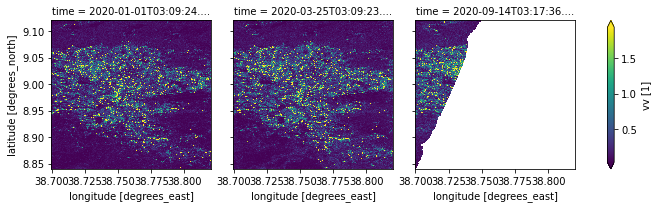

In [9]:
#polarisation band
timesteps = [0,12,40]
ds_S1.vv.where(ds_S1.mask==1).isel(time=timesteps).plot(col='time',robust=True);

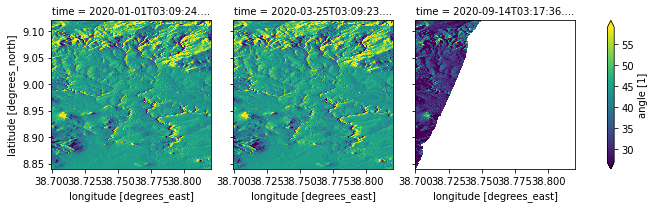

In [10]:
#looking angle 
ds_S1.angle.where(ds_S1.mask==1).isel(time=timesteps).plot(col='time',robust=True);

In [13]:
#identify and remove the scenes that are mostly null values 
No_px=len(ds_S1.longitude)*len(ds_S1.latitude)
valid=ds_S1.where(ds_S1.vv!=0).where(ds_S1.vh!=0).count(dim=('longitude','latitude'))
good=(valid.vh/No_px)>0.5
S1 = ds_S1.sel(time=good)
# S1.time.count()

In [14]:
S1 = S1.drop(['angle','area']);

## Generating Geomedian 

**Note**: `xr_geomedian` has several parameters we can set that will control its functionality.  

* Setting `num_thread=1` will disable the internal threading and instead allow parallelisation with `dask`. 

* The `eps` parameter controls the number of iterations to conduct; a good default is `1e-7.`  

* For numerical stability, it can also be advisable to scale surface reflectance float values in the dataset to 0-1 (instead of 0-10,000 as is the default for Sentinel-2).  We can do this by using the helper functions `to_f32`. We do this in the code cell below before we compute the geomedian. Note, this is not an essential step.

In [15]:
#generating geomedian for one year of observation 
grouped = S1.resample(time='1Y')
grouped 

DatasetResample, grouped over '__resample_dim__' 
1 groups with labels 2020-12-31.

In [16]:
#Ratio3: geomedian VH/VV
geomedian = xr_geomedian(S1)

/env/lib/python3.6/site-packages/odc/algo/_geomedian.py:106: RuntimeWarning: Mean of empty slice
  data = nangeomedian_pcm(xx_data, **kw)


In [17]:
%%time
geomedian = geomedian.compute()

CPU times: user 189 µs, sys: 0 ns, total: 189 µs
Wall time: 194 µs


In the above false color composites, low backscatter is measured bare earth which appears black or dark blue. High backscatter is measured in urban areas which appear green.

## Calculating Ratios for Comparison 

Three ratios for comparison:
- median vh and median vv calculated separately, then the ratio between median
- median of the vh/vv 
- geomedian vh/vv

In [18]:
#Ratio1 : ratio between median vh and median vv 
S1['vh_median'] = S1.vh.where(S1.mask==1).median(dim='time')
S1['vv_median'] = S1.vv.where(S1.mask==1).median(dim='time')
S1['vh_median_over_vv_median'] = S1['vh_median'] / S1['vv_median']

In [19]:
#compare the gray scale image of the following with other two 
#Ration2 : median of the VH/VV
S1['median_vh_over_vv'] = S1.vhvv.where(S1.mask==1).median(dim='time')

In [20]:
S1

<xarray.Dataset>
Dimensions:                   (latitude: 1400, longitude: 601, time: 31)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-01T03:09:24.75432...
  * latitude                  (latitude) float64 9.12 9.12 9.12 ... 8.84 8.84
  * longitude                 (longitude) float64 38.7 38.7 38.7 ... 38.82 38.82
    spatial_ref               int32 4326
Data variables:
    vv                        (time, latitude, longitude) float32 0.014318616...
    vh                        (time, latitude, longitude) float32 0.004497607...
    mask                      (time, latitude, longitude) uint8 1 1 1 ... 1 1 1
    vhvv                      (time, latitude, longitude) float32 0.31410903 ...
    vh_median                 (latitude, longitude) float32 0.00961546 ... 0....
    vv_median                 (latitude, longitude) float32 0.037878055 ... 0...
    vh_median_over_vv_median  (latitude, longitude) float32 0.25385305 ... 0....
    median_vh_over_vv         (latitude, longitude) float32 0.26847103 ... 0....
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### need a bit of plotting here 

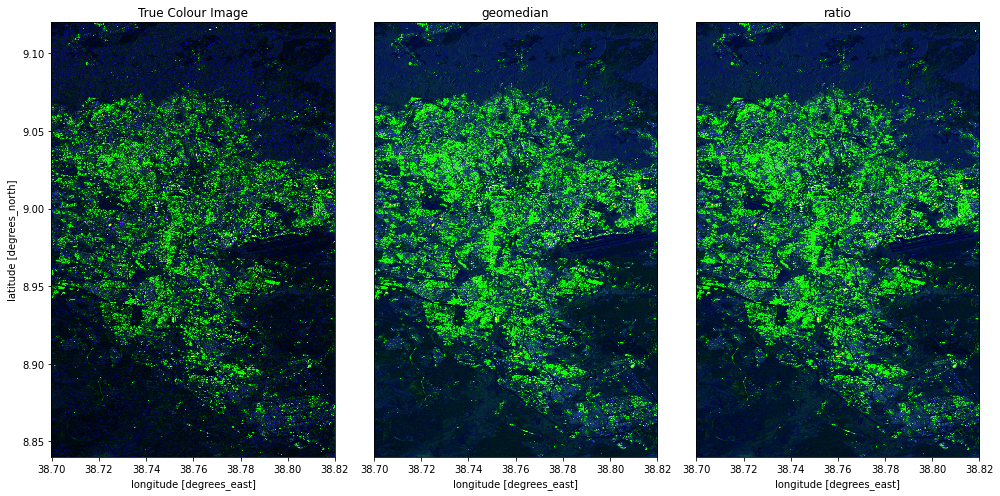

In [21]:
# Set up plot
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

# # Plot classified image
# predicted.Predictions.plot(ax=axes[0], 
#                cmap='viridis', 
#                add_labels=False, 
#                add_colorbar=False)

# Plot true color image
rgb(ds_S1.where(ds_S1.mask==1), ax=axes[0],bands=['vh','vv','vhvv'], index=0,percentile_stretch=(0.01, 0.99))

#plot geomedian image 
rgb(geomedian, ax=axes[1],bands=['vh','vv','vhvv'])

#plot image with band ratios 
rgb(S1.where(S1.mask==1), ax=axes[2], bands=['vh_median','vv_median','vh_median_over_vv_median'],index=0)

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
# Add plot titles
axes[0].set_title('Classified Image (yellow = Urban)')
axes[0].set_title('True Colour Image')
axes[1].set_title('geomedian')
axes[2].set_title('ratio')
plt.tight_layout();

In [26]:
zoomed_xmin = 3740000
zoomed_xmax = 3744590
zoomed_ymax = 1158000
zoomed_ymin = 1140000

Zoomed_area = ds_S1.sel(longitude = slice(zoomed_xmin, zoomed_xmax), latitude = slice(zoomed_ymax, zoomed_ymin))

In [28]:
Geomedian_zoomed = geomedian.sel(longitude = slice(zoomed_xmin, zoomed_xmax), latitude = slice(zoomed_ymax, zoomed_ymin))

In [30]:
S1_zoomed = S1.sel(longitude = slice(zoomed_xmin, zoomed_xmax), latitude = slice(zoomed_ymax, zoomed_ymin))

TypeError: only integer scalar arrays can be converted to a scalar index

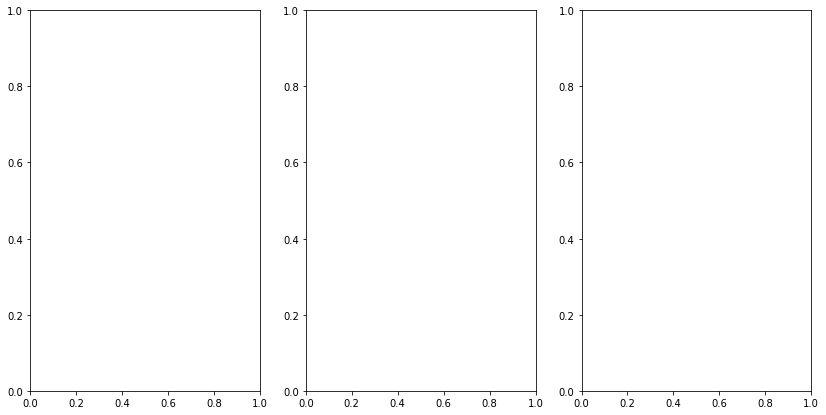

In [31]:
# Set up plot for zoom in presentation 
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

# # Plot classified image
# predicted.Predictions.plot(ax=axes[0], 
#                cmap='viridis', 
#                add_labels=False, 
#                add_colorbar=False)

# Plot true color image
rgb(Zoomed_area.where(ds_S1.mask==1), ax=axes[0],bands=['vh','vv','vhvv'], index=0,percentile_stretch=(0.01, 0.99))

#plot geomedian image 
rgb(Geomedian_zoomed, ax=axes[1],bands=['vh','vv','vhvv'])

#plot image with band ratios 
rgb(S1_zoomed.where(S1.mask==1), ax=axes[2], bands=['vh_median','vv_median','vh_median_over_vv_median'],index=0)

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
# Add plot titles
axes[0].set_title('Classified Image (yellow = Urban)')
axes[0].set_title('True Colour Image')
axes[1].set_title('geomedian')
axes[2].set_title('ratio')
plt.tight_layout();

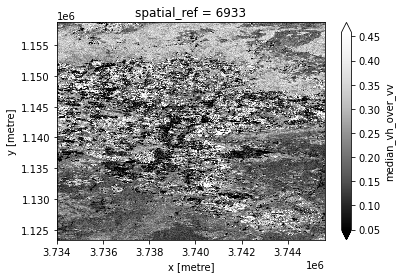

In [27]:
S1.median_vh_over_vv.plot(cmap="Greys_r", robust=True)
plt.show()

## Histogram Analysis for Sentinel-1 Dataset 

Histrograms below show bimodal distributions where low backscatter is measured over water. How this can be used to map water is demonstrated in the [Radar Water Detection](../Real_world_examples/Radar_water_detection.ipynb) notebook.

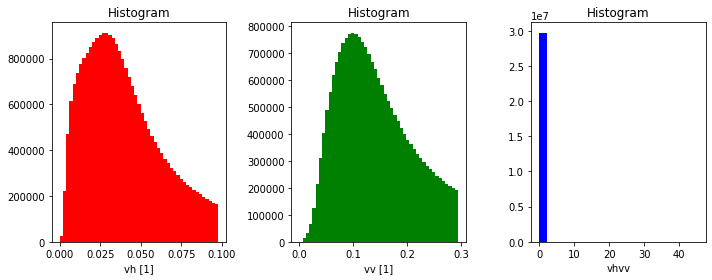

In [28]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
S1.vh.where(S1.mask==1).plot.hist(ax=ax[0], bins=np.arange(0, 0.1, 0.002), facecolor='red')
S1.vv.where(S1.mask==1).plot.hist(ax=ax[1], bins=np.arange(0, 0.3, 0.006), facecolor='green')
S1.vhvv.plot.hist(ax=ax[2], bins=20, facecolor='blue')
plt.tight_layout()

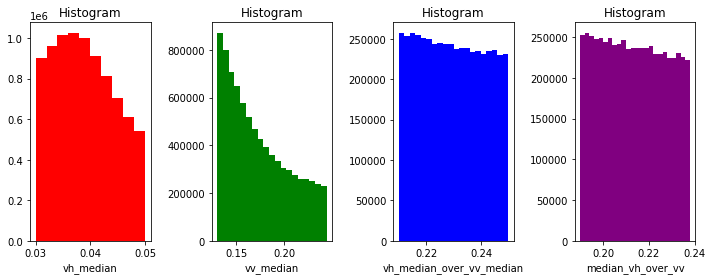

In [29]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 4, figsize=(10, 4))
S1.vh_median.where(S1.mask==1).plot.hist(ax=ax[0], bins=np.arange(0.03, 0.05, 0.002), facecolor='red')
S1.vv_median.where(S1.mask==1).plot.hist(ax=ax[1], bins=np.arange(0.13, 0.25, 0.006), facecolor='green')
S1.vh_median_over_vv_median.where(S1.mask==1).plot.hist(ax=ax[2], bins=np.arange(0.21, 0.25, 0.002), facecolor='blue')
S1.median_vh_over_vv.where(S1.mask==1).plot.hist(ax=ax[3], bins=np.arange(0.19, 0.24, 0.002), facecolor='purple')
plt.tight_layout()

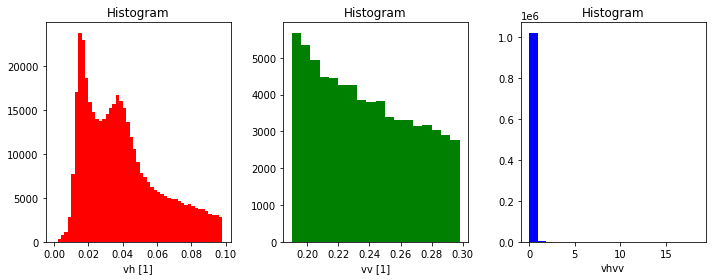

In [31]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
geomedian.vh.where(geomedian.mask==1).plot.hist(ax=ax[0], bins=np.arange(0, 0.1, 0.002), facecolor='red')
geomedian.vv.where(geomedian.mask==1).plot.hist(ax=ax[1], bins=np.arange(0.19, 0.3, 0.006), facecolor='green')
geomedian.vhvv.plot.hist(ax=ax[2], bins=20, facecolor='blue')
plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [32]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [33]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-12'